In [1]:
import pyomo.environ as pyo
import pyomo
pyomo.__version__

'6.4.2'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, matplotlib.pyplot as plt, pandas as pd, numpy as np, itertools, pprint, pyperclip

plt.rcParams['text.usetex'] = True

sys.path.append('../Teaching/')
import draw_MILO as draw

In [4]:
draw.SetOutputPath( r'.\work in progress' )
pp = pprint.PrettyPrinter(indent=2,width=128, compact=True, sort_dicts=True)

In [5]:
def SimpleDraw( model, isolines=True ):
    with plt.rc_context({'figure.figsize': (8,6), 'text.usetex' : True}):
        return draw.Draw( model, isolines=isolines, file_name=model.name+'.pdf' )

In [6]:
def CreateBIM():
    m   = pyo.ConcreteModel('BIM')
    
    m.I = pyo.RangeSet( 2 )
    
    m.x = pyo.Var( m.I, within=pyo.NonNegativeReals )

    @m.Objective( sense= pyo.maximize )
    def obj(m):
        return 12*m.x[1] + 9*m.x[2]

    @m.Constraint() 
    def silicon(m):   return  m.x[1] <= 1000
    @m.Constraint() 
    def germanium(m): return  m.x[2] <= 1500
    @m.Constraint()
    def plastic(m):   return    m.x[1] +   m.x[2] <= 1750
    @m.Constraint()
    def copper(m):    return  4*m.x[1] + 2*m.x[2] <= 4800
    
    return m

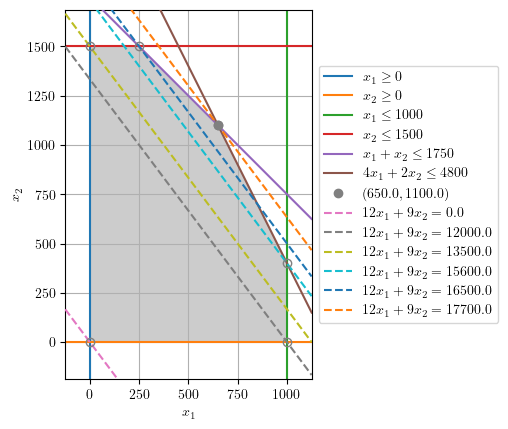

,x[1],x[2],value
0,0.0,0.0,0.0
1,0.0,1500.0,13500.0
4,250.0,1500.0,16500.0
5,650.0,1100.0,17700.0
2,1000.0,0.0,12000.0
3,1000.0,400.0,15600.0


In [7]:
draw.Draw( CreateBIM() )

In [8]:
m = CreateBIM()

In [9]:
m.pprint()

1 RangeSet Declarations
    I : Dimen=1, Size=2, Bounds=(1, 2)
        Key  : Finite : Members
        None :   True :   [1:2]

1 Var Declarations
    x : Size=2, Index=I
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :  None : False :  True : NonNegativeReals
          2 :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 12*x[1] + 9*x[2]

4 Constraint Declarations
    copper : Size=1, Index=None, Active=True
        Key  : Lower : Body            : Upper  : Active
        None :  -Inf : 4*x[1] + 2*x[2] : 4800.0 :   True
    germanium : Size=1, Index=None, Active=True
        Key  : Lower : Body : Upper  : Active
        None :  -Inf : x[2] : 1500.0 :   True
    plastic : Size=1, Index=None, Active=True
        Key  : Lower : Body        : Upper  : Active
        None :  -Inf : x[1] + x[2] 

In [10]:
interpreted = draw.Interpret(m)

In [11]:
pp.pprint( interpreted._asdict() )

{ 'coefficients': { 'copper': {'x[1]': 4, 'x[2]': 2},
                    'germanium': {'x[2]': 1},
                    'obj': {'x[1]': 12, 'x[2]': 9},
                    'plastic': {'x[1]': 1, 'x[2]': 1},
                    'silicon': {'x[1]': 1}},
  'formulas': { 'copper': '4*x[1] + 2*x[2]',
                'germanium': 'x[2]',
                'obj': '12*x[1] + 9*x[2]',
                'plastic': 'x[1] + x[2]',
                'silicon': 'x[1]'},
  'lower_constraint': {'copper': None, 'germanium': None, 'plastic': None, 'silicon': None},
  'lower_variable': {'x[1]': 0, 'x[2]': 0},
  'objective': {'obj': 'max'},
  'upper_constraint': {'copper': 4800, 'germanium': 1500, 'plastic': 1750, 'silicon': 1000},
  'upper_variable': {'x[1]': None, 'x[2]': None}}


In [12]:
draw.Summary(interpreted)[0]

,L,x[1],x[2],U
silicon,NaN,1.0,NaN,1000.0
germanium,NaN,NaN,1.0,1500.0
plastic,NaN,1.0,1.0,1750.0
copper,NaN,4.0,2.0,4800.0
x[1],0.0,NaN,NaN,NaN
x[2],0.0,NaN,NaN,NaN
obj,NaN,12.0,9.0,NaN


In [13]:
pyperclip.copy( draw.to_latex(m) )

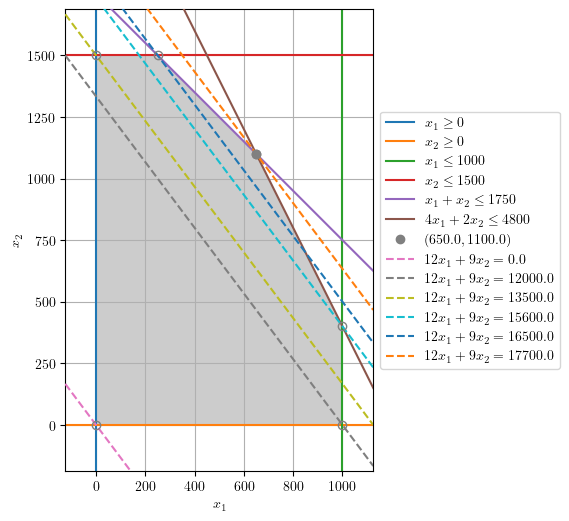

,x[1],x[2],value
0,0.0,0.0,0.0
1,0.0,1500.0,13500.0
4,250.0,1500.0,16500.0
5,650.0,1100.0,17700.0
2,1000.0,0.0,12000.0
3,1000.0,400.0,15600.0


In [14]:
SimpleDraw( CreateBIM(), True )

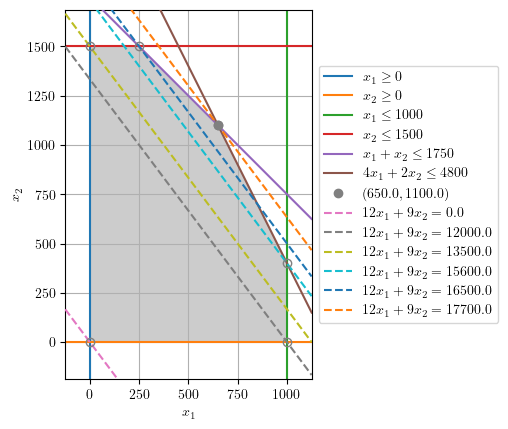

In [15]:
basicfeasiblesolutions = draw.Draw( CreateBIM(), 'BuildingMicrochips.pdf' )

In [16]:
basicfeasiblesolutions.rename(columns={'x1': '$x_1$', 'x2': '$x_2$'}).astype(int).style.to_latex(draw._output_path+'chips.tex')
if 'google.colab' in sys.modules:
    import os
    from google.colab import files
    files.download( 'chips.tex' )

# Chapter three

The first version was a copy of [the model on this deck](http://web.tecnico.ulisboa.pt/mcasquilho/compute/_linpro/TaylorB_module_c.pdf]).

Below several versions of possible models.

In [17]:
def CreateBBaExample():
    model    = pyo.ConcreteModel('BBa')
    
    model.x1 = pyo.Var( within=pyo.NonNegativeReals )
    model.x2 = pyo.Var( within=pyo.NonNegativeReals )

    model.obj = pyo.Objective( sense= pyo.maximize
                                    , expr = 2*model.x1 + 3*model.x2 )

    model.c1  = pyo.Constraint(expr =  2*model.x1 +  1*model.x2 <=  10)
    model.c2  = pyo.Constraint(expr =  3*model.x1 +  6*model.x2 <=  40)
    
    return model

In [18]:
m = CreateBBaExample()

In [19]:
rep = draw.Interpret(m)

In [20]:
rep

Canonical(lower_variable={'x1': 0, 'x2': 0}, upper_variable={'x1': None, 'x2': None}, lower_constraint={'c1': None, 'c2': None}, upper_constraint={'c1': 10, 'c2': 40}, formulas={'c1': '2*x1 + x2', 'c2': '3*x1 + 6*x2', 'obj': '2*x1 + 3*x2'}, coefficients={'c1': {'x1': 2, 'x2': 1}, 'c2': {'x1': 3, 'x2': 6}, 'obj': {'x1': 2, 'x2': 3}}, objective={'obj': 'max'})

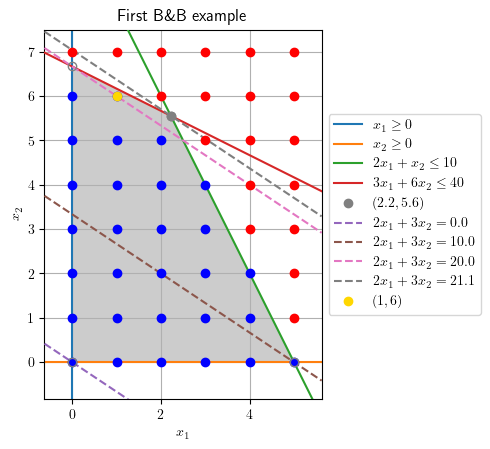

,x1,x2,value
0,0.0,0.0,0.0
1,0.0,6.7,20.0
3,2.2,5.6,21.1
2,5.0,0.0,10.0


In [21]:
draw.Draw( CreateBBaExample(), integer=True, isolines=True, file_name=CreateBBaExample().name+'.pdf', title='First B\&B example' )

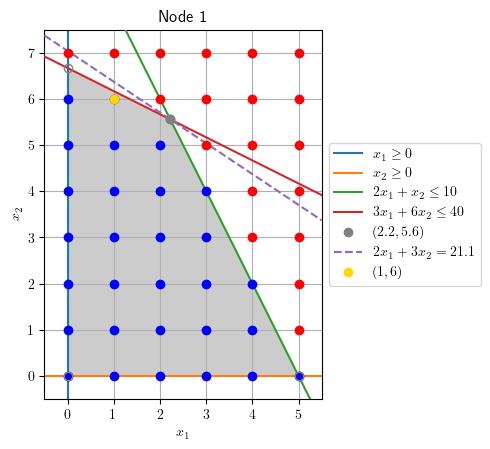

[2.22222222 5.55555556]


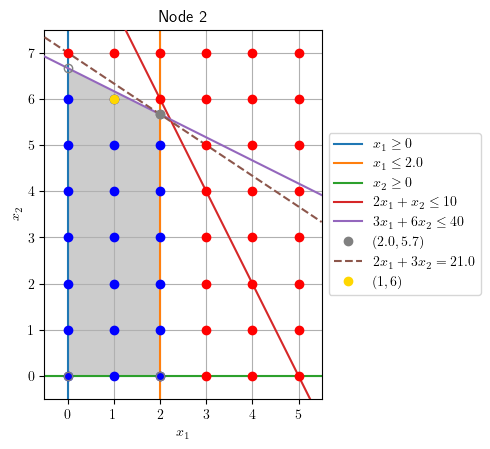

[2.         5.66666667]


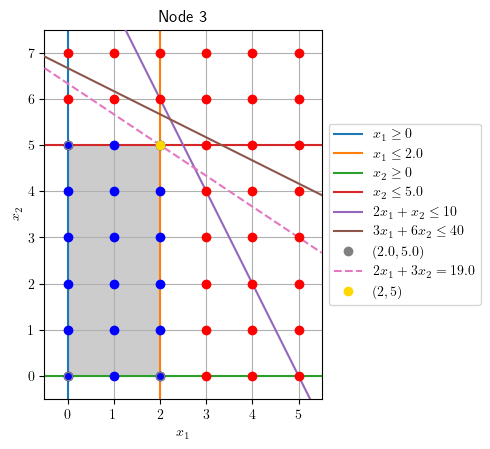

[2. 5.]


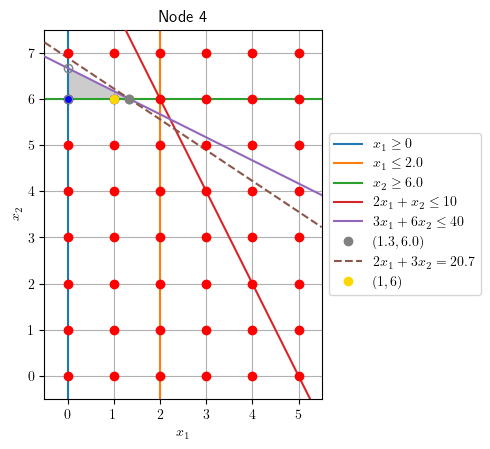

[1.33333333 6.        ]


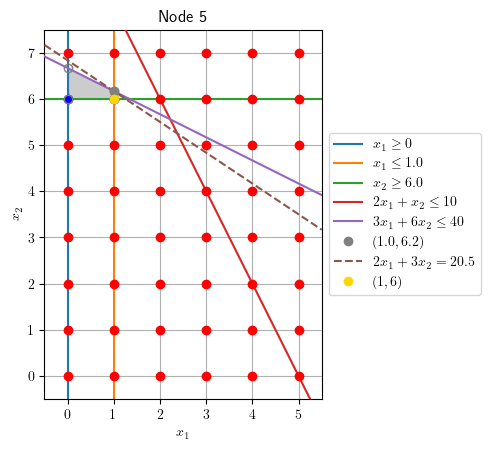

[1.         6.16666667]


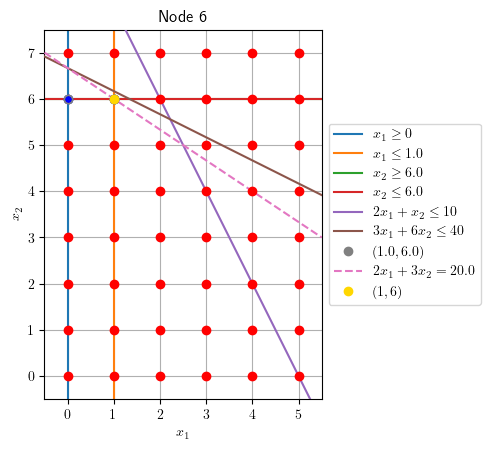

[1. 6.]
    model.name="BBa";
      - termination condition: infeasibleOrUnbounded
      - message from solver: <undefined>


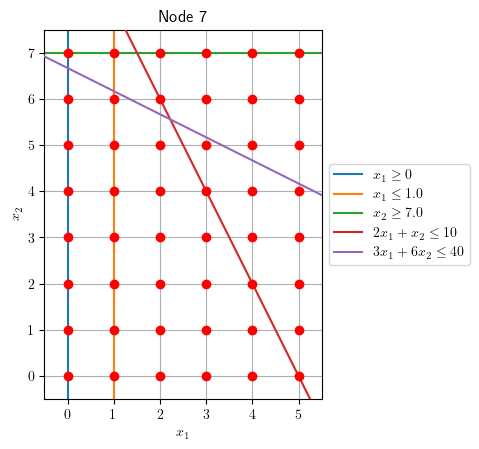

    model.name="BBa";
      - termination condition: infeasibleOrUnbounded
      - message from solver: <undefined>


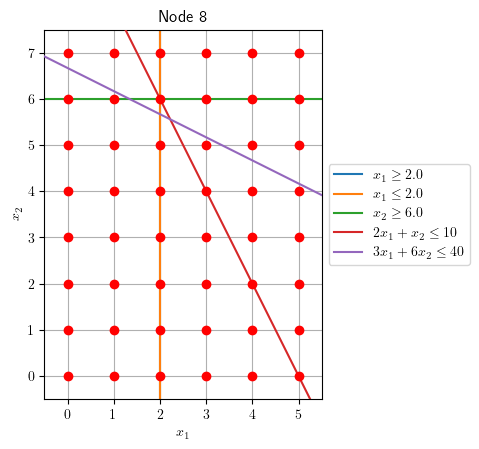

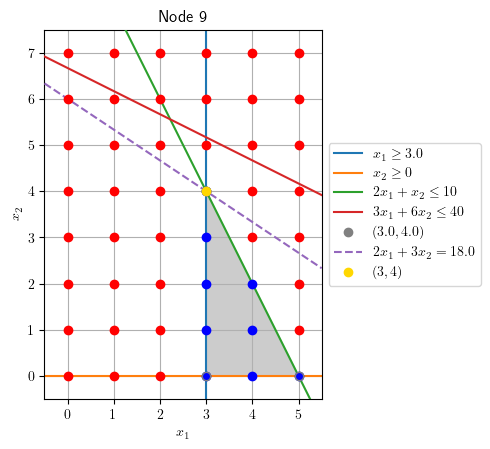

In [22]:
sol,root = draw.BB( CreateBBaExample(), solver='gurobi_direct' )

In [23]:
draw.ToTikz(root, 'BBa.tex', fig_only=True )

In [24]:
draw.DrawBB(root, 'BB.pdf')

In [25]:
draw.DotExporter(root).to_picture(draw._output_path+'BBplain.pdf')

In [26]:
def CreateBBbExample():
    m    = pyo.ConcreteModel('BBb')
    
    m.x1 = pyo.Var( within=pyo.NonNegativeReals )
    m.x2 = pyo.Var( within=pyo.NonNegativeReals )

    m.obj= pyo.Objective( sense= pyo.maximize
                        , expr =  1*m.x1 + 2*m.x2 )

    m.c1 = pyo.Constraint(expr = -4*m.x1 + 5*m.x2 <= 11)
    m.c2 = pyo.Constraint(expr =  5*m.x1 - 2*m.x2 <=  9)
    
    return m

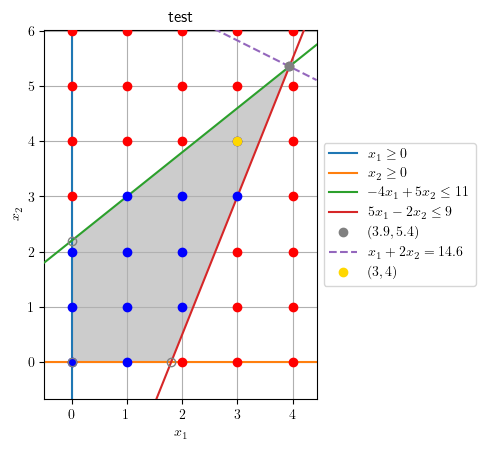

,x1,x2,value
0,0.0,0.0,0.0
1,0.0,2.2,4.4
2,1.8,0.0,1.8
3,3.9,5.4,14.6


In [27]:
draw.Draw( CreateBBbExample(), integer=True, isolines=False, file_name=None, title='test' )

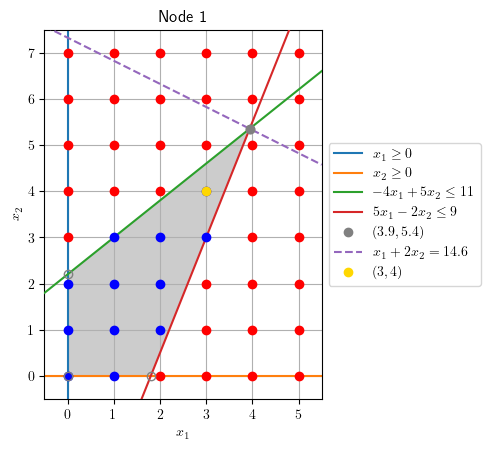

[3.94117647 5.35294118]


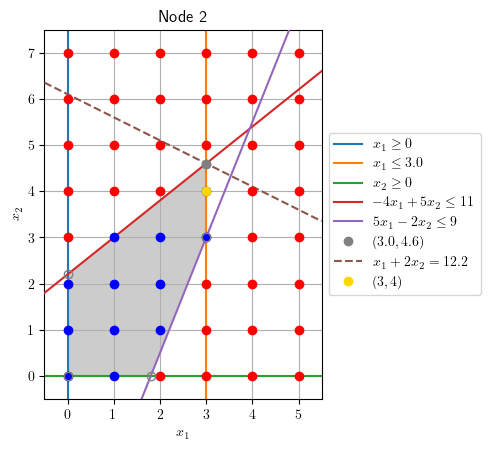

[3.  4.6]


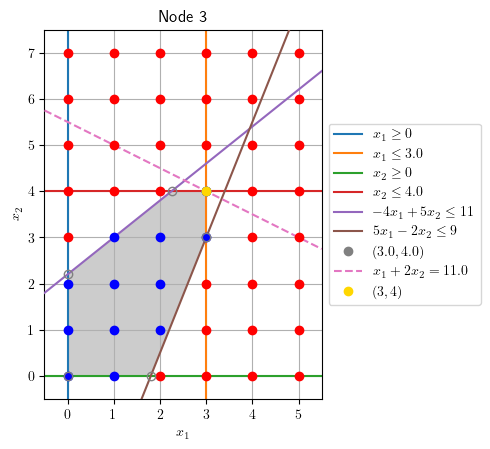

[3. 4.]
    model.name="BBb";
      - termination condition: infeasibleOrUnbounded
      - message from solver: <undefined>


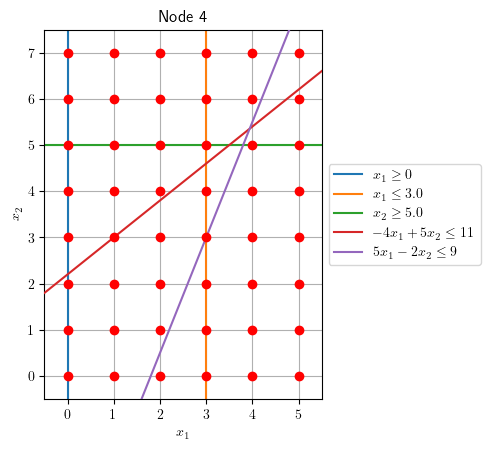

    model.name="BBb";
      - termination condition: infeasible
      - message from solver: <undefined>


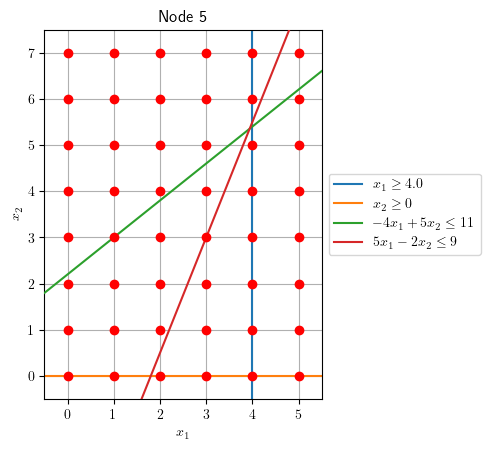

In [28]:
sol,root = draw.BB( CreateBBbExample(), solver='gurobi_direct' )

In [29]:
draw.ToTikz(root, 'BBb.tex', fig_only=True )

In [30]:
draw.DotExporter(root).to_dotfile(draw._output_path+'test.dot')

In [31]:
draw.DrawBB(root,'BBBook.pdf')

In [32]:
def CreateBIMmodified():
    m    = pyo.ConcreteModel('BIMmodified')
    
    m.x1 = pyo.Var( within=pyo.NonNegativeReals )
    m.x2 = pyo.Var( within=pyo.NonNegativeReals )

    m.obj       = pyo.Objective( sense= pyo.maximize
                               , expr = 12*m.x1 + 9*m.x2 )

    m.silicon   = pyo.Constraint(expr =    m.x1          <= 900 )
    m.germanium = pyo.Constraint(expr =             m.x2 <= 1350)
    m.plastic   = pyo.Constraint(expr =    m.x1 +   m.x2 <= 1801)
    m.copper    = pyo.Constraint(expr =  4*m.x1 + 2*m.x2 <= 4903)
    
    return m

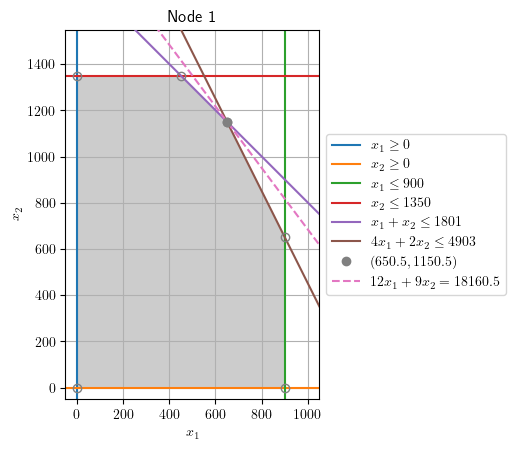

[ 650.5 1150.5]


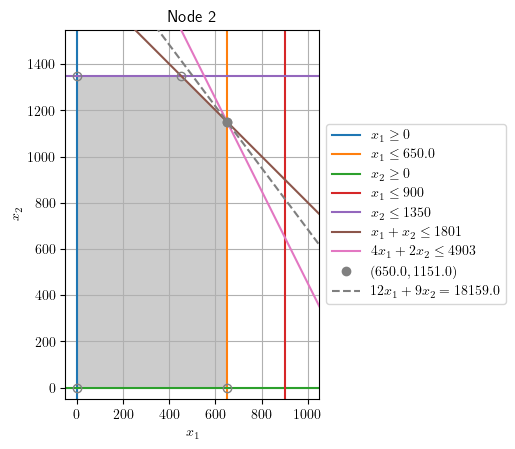

[ 650. 1151.]


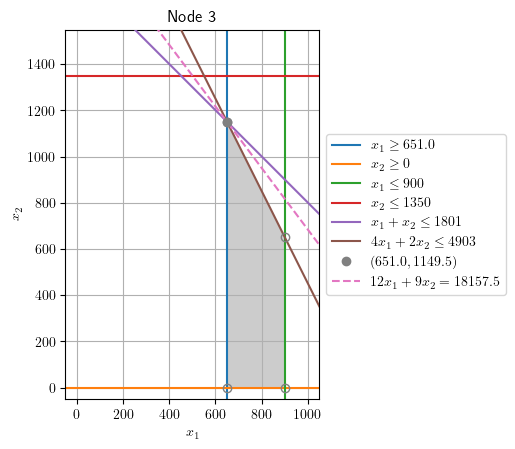

In [33]:
sol,root = draw.BB( CreateBIMmodified(), solver='gurobi_direct', draw_integer=False, xlim=(-50,1050), ylim=(-50,1550) )

In [34]:
draw.ToTikz(root, 'BIMmodified.tex', fig_only=True )

In [35]:
def CreateBIMperturbed():
    m    = pyo.ConcreteModel('BIMperturbed')
    
    m.x1 = pyo.Var( within=pyo.NonNegativeReals )
    m.x2 = pyo.Var( within=pyo.NonNegativeReals )

    m.obj       = pyo.Objective( sense= pyo.maximize
                               , expr = 12*m.x1 + 9*m.x2 )

    m.silicon   = pyo.Constraint(expr =    m.x1                <= 1000 )
    m.germanium = pyo.Constraint(expr =                   m.x2 <= 1500)
    m.plastic   = pyo.Constraint(expr =    m.x1    +      m.x2 <= 1750)
    m.copper    = pyo.Constraint(expr =  4.04*m.x1 + 2.02*m.x2 <= 4800)
    
    return m

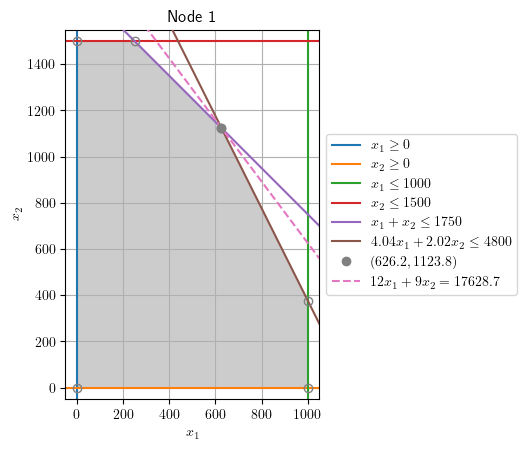

[ 626.23762376 1123.76237624]


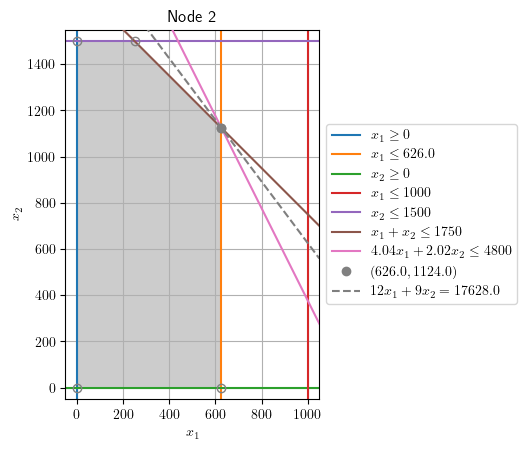

[ 626. 1124.]


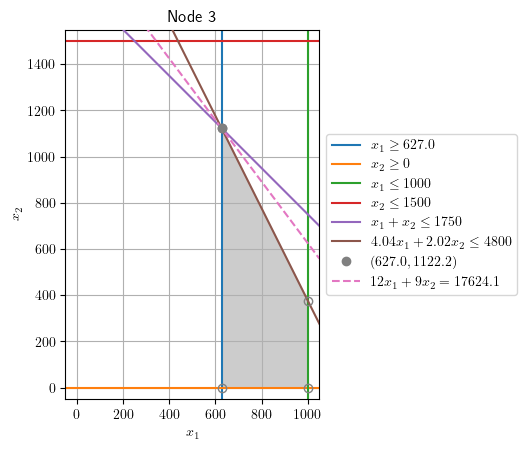

In [36]:
sol,root = draw.BB( CreateBIMperturbed(), solver='gurobi_direct', draw_integer=False, xlim=(-50,1050), ylim=(-50,1550) )

In [37]:
draw.ToTikz(root, 'BIMperturbed.tex', fig_only=True )

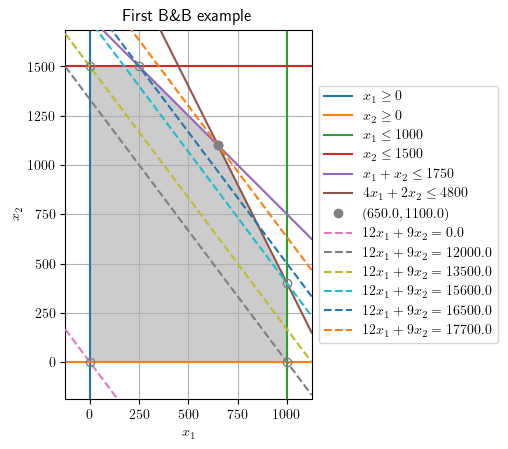

,x[1],x[2],value
0,0.0,0.0,0.0
1,0.0,1500.0,13500.0
4,250.0,1500.0,16500.0
5,650.0,1100.0,17700.0
2,1000.0,0.0,12000.0
3,1000.0,400.0,15600.0


In [38]:
draw.Draw( CreateBIM(), integer=False, isolines=True, file_name=None, title='First B\&B example' )

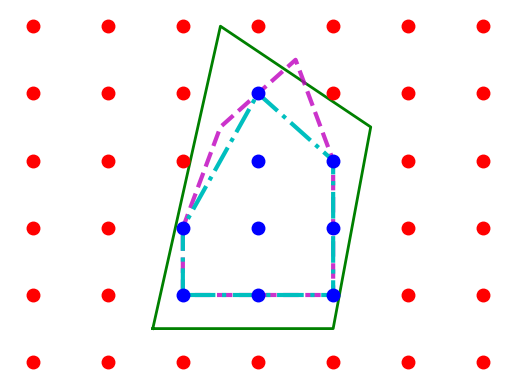

In [39]:
nx,ny = 6,5
F = { (2,1), (3,1), (4,1), (2,2), (3,2), (4,2), (3,3), (4,3), (3,4) }

import itertools  
points = list(itertools.product( range(0,nx+1), range(0,ny+1) ) )
feasible   = [ p for p in points if p in F ]
infeasible = [ p for p in points if not p in F ]
if infeasible:
    plt.plot( *zip(*infeasible), 'ro', zorder=2, markersize=9)
if feasible:
    plt.plot( *zip(*feasible), 'bo', zorder=2, markersize=9)
    
def Pol( coord, style, alpha, width ):
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    plt.plot(*zip(*coord),style, alpha=alpha, linewidth=width, zorder=1) 

Pol( [ (1.6,.5), (2.5,5), (4.5,3.5), (4,.5) ], 'g-', 1, 2 )
Pol( [ (2,1), (2,2), (2.5, 3.5), (3.5, 4.5), (4,3), (4,1) ], 'm--', .8, 3 )
Pol( [ (2,1), (2,2), (3,4), (4,3), (4,1) ], 'c-.', 1, 3 )

ax = plt.gca()

# Hide the right and top spines
for position in ['left','right','top','bottom']:
    ax.spines[position].set_visible(False)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig( draw._output_path+'3regions.pdf', bbox_inches='tight', pad_inches=0 )
plt.show()